In [9]:
# Math
import numpy as np
from scipy.stats import multivariate_normal

# Visualization
import matplotlib
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

plt.style.use('qualitative.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

class_colors = [colors[1], colors[0], colors[4]]

In [10]:
def get_gaussians():
    mu_1 = np.array([-8, 0])
    mu_2 = np.array([8, 8])

    c_1 = np.array([[3, 2.5], [2.5, 3]])*100
    c_2 = np.array([[5, -3], [-3, 5]])*30

    return get_gaussian_distributions([mu_1, mu_2], [c_1, c_2])


def get_gaussian_distributions(mus, covars):
    return [multivariate_normal(mean=mu, cov=cov) for mu, cov in zip(mus, covars)]


def get_gt_probabilities(x):
    distributions = get_gaussians()
    lpexp = [distrib.pdf(x) for distrib in distributions]
    sm = sum(lpexp)
    return [float(_/sm) for _ in lpexp]


def prepare_dataset(N: int = 100):
    """
    Prepares the training dataset. Returns Class x N samples, N samples of each class.

    Args:
        N (int, optional): Number of samples per class.

    Returns:
        X: TensorType["batch", "Class*N"]; data
        y: TensorType["Class*N"]; labels
    """
    distributions = get_gaussians()
    samples = [distribution.rvs(N) for distribution in distributions]
    labels = [np.array([i]*int(N)) for i in range(len(distributions))]

    X = np.concatenate(samples)
    y = np.concatenate(labels)
    return X, y, distributions


def visualize_gaussian(distribution,
                       N: int = 200,
                       xmin: float = -20,
                       xmax: float = 20,
                       ymin: float = -20,
                       ymax: float = 25,
                       color='k',
                       levels=None):
    X = np.linspace(xmin, xmax, N)
    Y = np.linspace(ymin, ymax, N)
    X, Y = np.meshgrid(X, Y)
    pos = np.dstack((X, Y))
    Z = distribution.pdf(pos)
    ix = np.unravel_index(np.argmax(Z, axis=None), Z.shape)
    plt.contour(X, Y, Z, levels=levels, colors=color, cmap=None, alpha=0.5, linewidths=2)


def visualize_decision_boundary(clf,
                                axis,
                                N: int = 1000,
                                xmin: float = -20,
                                xmax: float = 20,
                                ymin: float = -20,
                                ymax: float = 25,
                                levels=None):
    X = np.linspace(xmin, xmax, N)
    Y = np.linspace(ymin, ymax, N)
    X, Y = np.meshgrid(X, Y)
    Z = clf.predict(np.c_[X.ravel(), Y.ravel()])
    Z = Z.reshape(X.shape)
    axis.contourf(X, Y, Z, cmap=matplotlib.colors.ListedColormap(
        [class_colors[0], class_colors[1]]), alpha=0.2, linewidths=0)


def visualize_optimal_decision_boundary(distributions,
                                        N: int = 1000,
                                        xmin: float = -20,
                                        xmax: float = 20,
                                        ymin: float = -20,
                                        ymax: float = 25):
    X = np.linspace(xmin, xmax, N)
    Y = np.linspace(ymin, ymax, N)
    X, Y = np.meshgrid(X, Y)
    pos = np.dstack((X, Y))
    Zs = [distribution.pdf(pos) for distribution in distributions]
    Z = np.array([np.argmax(values)
                 for values in zip(*[_.flatten() for _ in Zs])])
    Z = Z.reshape(X.shape)
    plt.contourf(X, Y, Z, cmap=matplotlib.colors.ListedColormap(
        [class_colors[0], class_colors[1]]), alpha=0.2)

In [11]:
np.random.seed(1)
X, y, distributions = prepare_dataset(N=2)
bad_clf = LogisticRegression()
bad_clf.fit(X+5*np.random.rand(*X.shape), y)

X, y, distributions = prepare_dataset(N=100)
good_clf = LogisticRegression()
good_clf.fit(X, y)

clf = MLPClassifier(solver='adam', 
                    alpha=0,
                    hidden_layer_sizes=(100, 100), 
                    max_iter=500,
                    random_state=1)
clf.fit(X, y)

Xmin = np.min(X[:,0])
Xmax = np.max(X[:,0])
Ymin = np.min(X[:,1])
Ymax = np.max(X[:,1])

/home/hakka/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


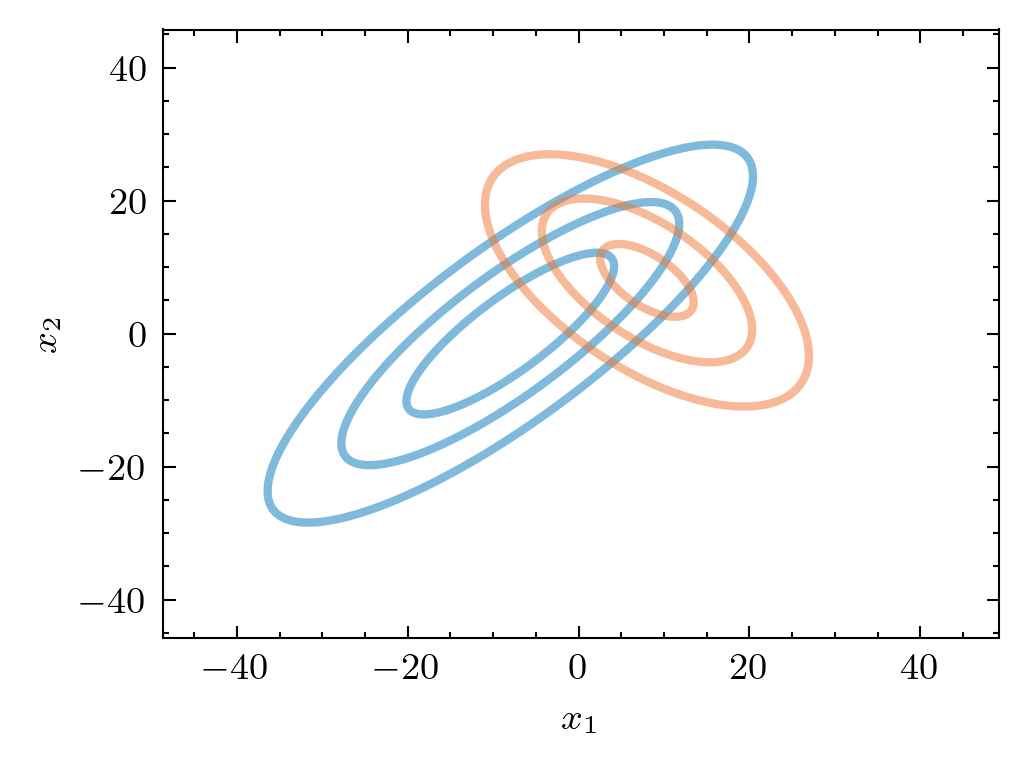

In [12]:
for distribution, color in zip(distributions, class_colors):
    visualize_gaussian(distribution=distribution, color=color, levels=3, xmin=Xmin, xmax=Xmax, ymin=Ymin, ymax=Ymax)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.tight_layout()
plt.show()

Bayes optimal classifier attains the best possible risk. Be sure to understand that this risk does not have to be 0.

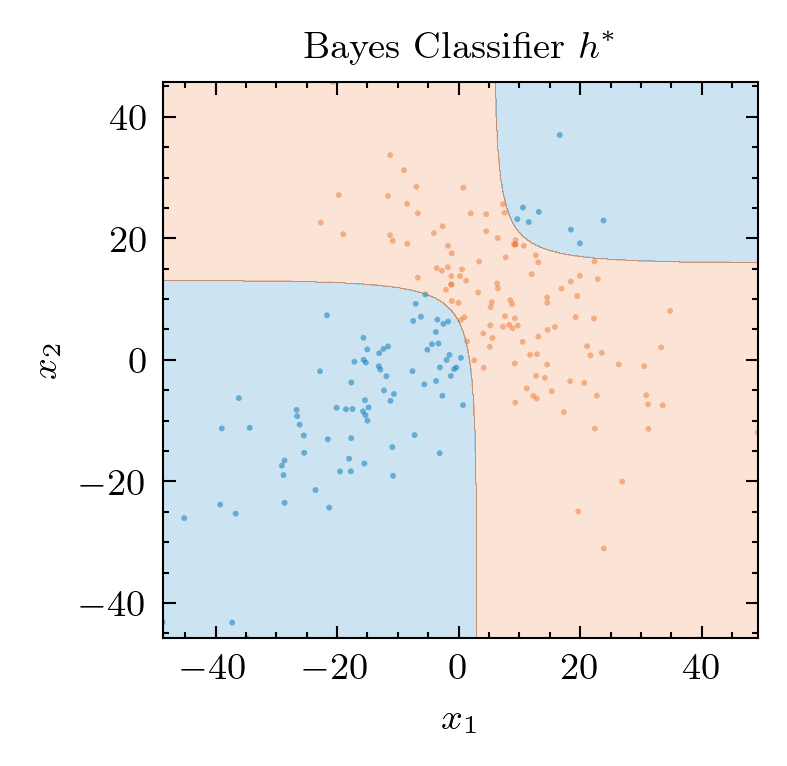

In [13]:
gt_probs = [get_gt_probabilities(x) for x in X]
y_pred = np.array([np.argmax(probs) for probs in gt_probs])
cs = [class_colors[pred] for pred in y_pred]

plt.scatter(X[:,0], X[:,1], s=2, c=cs, alpha=0.5, linewidths=0)

visualize_optimal_decision_boundary(distributions=distributions, xmin=Xmin, xmax=Xmax, ymin=Ymin, ymax=Ymax)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Bayes Classifier $h^*$")
plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

But how do we parameterize it? I could plot the previous picture only because I explicitely know the true probability distribution, i.e., I know for what $x$ it is true that $p(y_1|x)>p(y_2|x)$.

Consider hypothesis space of all possible linear classifier. That is ...

/tmp/ipykernel_30812/3882778150.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  xs = [-1/np.tan(angle), 1/np.tan(angle)]


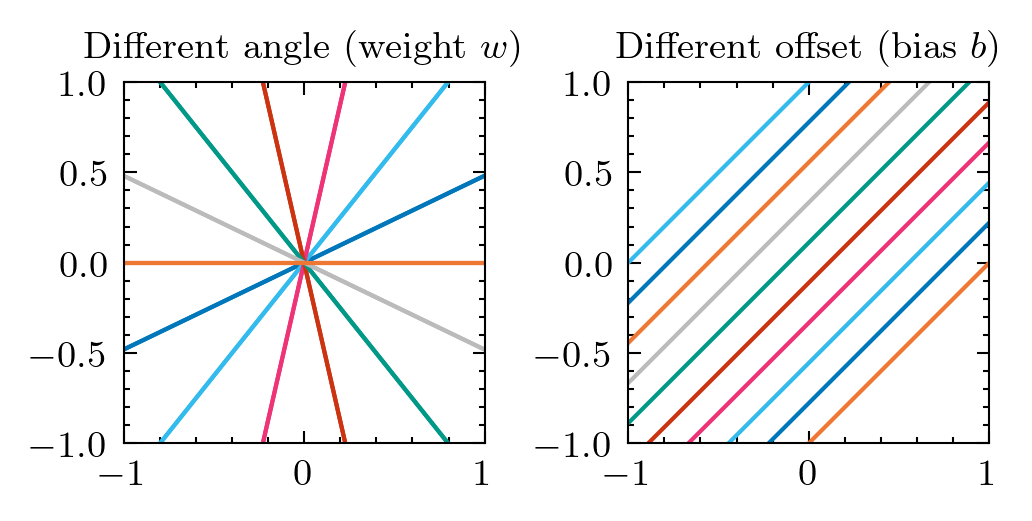

In [14]:
x_min=-1
x_max=1
y_min=-1
y_max=1

fig, axes = plt.subplots(1,2)

for i in np.linspace(0, 2*np.pi, 15, endpoint=True):
    angle = i
    xs = [-1/np.tan(angle), 1/np.tan(angle)]    
    ys = [-1 , 1]
    axes[0].plot(xs, ys)

axes[0].set_title("Different angle (weight $w$)")

for i in np.linspace(-1, 1, 10, endpoint=True):
    angle = np.pi/4
    xs = [-1/np.tan(angle), 1/np.tan(angle)]
    ys = [-1+i , 1+i]
    axes[1].plot(xs, ys)

axes[1].set_title("Different offset (bias $b$)")

for ax in axes:
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.set_aspect('equal', adjustable='box')
    
plt.tight_layout()
plt.show()

We can choose any angle and any offset we want.

If we choose the "best" model from our hypothesis space, it will have 0 "estimation error".
If we choose a "bad" model from our hypothesis space, it will have high "estimation error".

Both models, however, will have high "approximation error", because the overall best (Bayes optimal) model is not a linear model.

In [15]:
fig, axes = plt.subplots(1,2)
gt_probs = [get_gt_probabilities(x) for x in X]
y_pred = np.array([np.argmax(probs) for probs in gt_probs])
cs = [class_colors[pred] for pred in y_pred]

visualize_decision_boundary(clf=bad_clf, xmin=Xmin, xmax=Xmax, ymin=Ymin, ymax=Ymax, axis=axes[0])
axes[0].set_title('')

visualize_decision_boundary(clf=good_clf, xmin=Xmin, xmax=Xmax, ymin=Ymin, ymax=Ymax, axis=axes[1])
axes[0].set_title('')

for ax in axes:
    ax.scatter(X[:,0], X[:,1], s=2, c=cs, alpha=0.5, linewidths=0)
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.set_aspect('equal', adjustable='box')

axes[0].set_title('High Estimation Error\nHigh Approximation Error')
axes[1].set_title('Low Estimation Error\nHigh Approximation Error')

plt.tight_layout()
plt.show()

/tmp/ipykernel_30812/498629733.py:72: UserWarning: linewidths is ignored by contourf
  axis.contourf(X, Y, Z, cmap=matplotlib.colors.ListedColormap(
/tmp/ipykernel_30812/498629733.py:72: UserWarning: linewidths is ignored by contourf
  axis.contourf(X, Y, Z, cmap=matplotlib.colors.ListedColormap(


If we consider a more complex hypothesis space, e.g., multi-layer-perceptron (fully connected neural network), we can be sure that the "approximation error" will decrease (or stay the same), because our new hypothesis class (space) contains the previous hypothesis class (space) as well as other models.

I.e., our new hypothesis class (space) contains all linear models, but it also contains some nonlinear models. 

Surely, the best neural network is a good model. But can we find the best neural network? If we do not find the best neural network, the "estimation error" could increase.

/tmp/ipykernel_30812/498629733.py:72: UserWarning: linewidths is ignored by contourf
  axis.contourf(X, Y, Z, cmap=matplotlib.colors.ListedColormap(
/tmp/ipykernel_30812/498629733.py:72: UserWarning: linewidths is ignored by contourf
  axis.contourf(X, Y, Z, cmap=matplotlib.colors.ListedColormap(


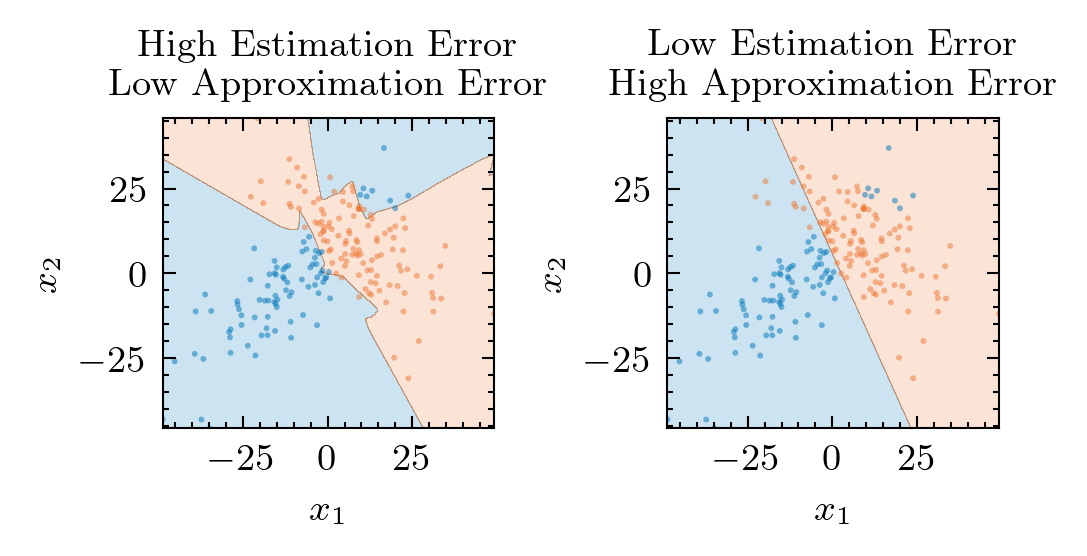

In [16]:
fig, axes = plt.subplots(1,2)
gt_probs = [get_gt_probabilities(x) for x in X]
y_pred = np.array([np.argmax(probs) for probs in gt_probs])
cs = [class_colors[pred] for pred in y_pred]

visualize_decision_boundary(clf=clf, xmin=Xmin, xmax=Xmax, ymin=Ymin, ymax=Ymax, axis=axes[0])
axes[0].set_title('')

visualize_decision_boundary(clf=good_clf, xmin=Xmin, xmax=Xmax, ymin=Ymin, ymax=Ymax, axis=axes[1])
axes[0].set_title('')

for ax in axes:
    ax.scatter(X[:,0], X[:,1], s=2, c=cs, alpha=0.5, linewidths=0)
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.set_aspect('equal', adjustable='box')

axes[0].set_title('High Estimation Error\nLow Approximation Error')
axes[1].set_title('Low Estimation Error\nHigh Approximation Error')

plt.tight_layout()
plt.show()

These two errors are always at an interplay. If I choose a more complex hypothesis space, I can reach better approximation error. However, there is then a chance that the estimation error will be much larger.